In [1]:
from fastai.vision.all import *
from fastai.callback.wandb import WandbCallback
from sklearn.model_selection import StratifiedKFold

from ipyexperiments.ipyexperiments import IPyExperimentsPytorch
import timm,wandb,albumentations as A

import IPython.display as disp
from timm.models import safe_model_name, set_fast_norm
from timm.models.layers import create_classifier, SelectAdaptivePool2d

In [2]:
%env WANDB_SILENT=true
warnings.filterwarnings('ignore')

env: WANDB_SILENT=true


In [8]:
VERSION  = "NB_EXP_014"
EXP_NAME = f"{VERSION}_efficientnetv2_m"

CSV_PATH     = Path('/data/train.csv')
DATA_PATH    = Path('/data/')
IMAGE_FOLDER = Path('/data/train/')
MODEL_FOLDER = Path(f'/runs/{VERSION}')

os.makedirs(MODEL_FOLDER, exist_ok=True)

LABELS = sorted(['broken', 'pure', 'discolored', 'silkcut'])
labels_class_map = {v:k for k,v in enumerate(LABELS)}
labels_class_map_rev = {v:k for k,v in labels_class_map.items()}

VIEWS = sorted(['top', 'bottom'])
views_class_map = {v:k for k,v in enumerate(VIEWS)}
views_class_map_rev = {v:k for k,v in views_class_map.items()}

TIMM_MODEL  = "tf_efficientnetv2_m_in21ft1k"

NFOLDS = 5
BS = 32
SZ = 320

TRAIN_AUG = A.Compose([
    A.Resize(SZ, SZ),
    A.Transpose(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.3, rotate_limit=360, border_mode=0, p=0.75),
    A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1),
    A.Blur(p=0.5),
    A.CoarseDropout(max_height=int(32*(SZ/512)), max_width=int(32*(SZ/512)), p=0.75), 
])

CROP_PCT = 1.0
SCALE_SZ = int(math.floor(SZ / CROP_PCT))
VALID_AUG = A.Compose([A.Resize(SCALE_SZ, SCALE_SZ), A.CenterCrop(SZ, SZ)])

In [9]:
all_df = pd.read_csv(CSV_PATH)
all_df.head()

,seed_id,view,image,label
0,0,top,train/00000.png,broken
1,1,bottom,train/00001.png,pure
2,3,top,train/00003.png,broken
3,4,top,train/00004.png,pure
4,5,top,train/00005.png,discolored


In [10]:
folds = all_df.copy()
fold_splits = []

Fold = StratifiedKFold(n_splits=NFOLDS, shuffle=True, random_state=42)
for n, (train_index, val_index) in enumerate(Fold.split(folds, folds["label"])):
    fold_splits.append(val_index)
    folds.loc[val_index, 'fold'] = int(n)
folds['fold'] = folds['fold'].astype(int)

In [11]:
@Transform
def hflip(x: TensorTypes): return x.flip(3)

@Transform
def vflip(x: TensorTypes): return x.flip(2)

class AlbumentationsTransform(RandTransform):
    "A transform handler for multiple `Albumentation` transforms"
    split_idx,order=None,2
    def __init__(self, train_aug, valid_aug): store_attr()
    
    def before_call(self, b, split_idx):
        self.idx = split_idx
    
    def encodes(self, img: PILImage):
        if self.idx == 0:
            aug_img = self.train_aug(image=np.array(img))['image']
        else:
            aug_img = self.valid_aug(image=np.array(img))['image']
        return PILImage.create(aug_img)

In [12]:
def get_dls(fold:int, bs:int, *args, **kwargs):
    
    aug_tfm = AlbumentationsTransform(TRAIN_AUG, VALID_AUG)
    item_tfms = [aug_tfm, ToTensor]
    batch_tfms = [IntToFloatTensor, Normalize.from_stats(*imagenet_stats)]
    
    dblock = DataBlock(
        blocks     = (ImageBlock, CategoryBlock(vocab=LABELS)),
        splitter   = IndexSplitter(fold_splits[fold]),
        get_x      = ColReader('image', pref=DATA_PATH),
        get_y      = [ColReader('label')],
        item_tfms  = item_tfms,
        batch_tfms = batch_tfms )
    
    dls = dblock.dataloaders(folds, bs=bs)
    return dls

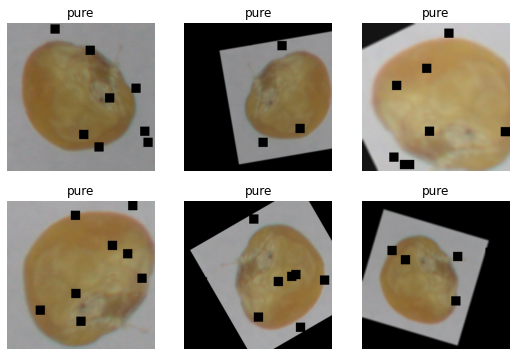

In [13]:
dls = get_dls(0, size=SZ, bs=BS)
dls.show_batch(max_n=6, unique=True)

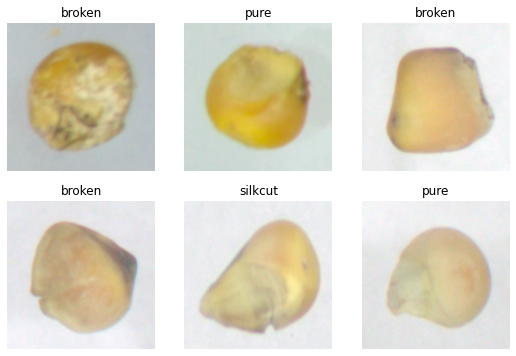

In [14]:
dls.valid.show_batch(max_n=6)

In [15]:
from timm.models.helpers import group_modules, group_parameters

def timm_get_module_names(m):
    modules_names = group_modules(m, m.group_matcher(coarse=True))
    return L(modules_names.values())[:-1] #cut timm head

def timm_get_param_names(m):
    param_names = group_parameters(m, m.group_matcher(coarse=True))
    return L(param_names.values())[:-1] #cut timm head

def timm_body_params(timm_model, cut=-1):
    param_names = timm_get_param_names(timm_model)
    return L(param_names[:cut].concat(), param_names[cut:].concat())

def timm_split(m, cut=-1):
    "Splitter function for timm models"
    timm_model, head = m[0].model, m[1]
    body_groups = [g.map(timm_model.get_parameter) for g in timm_body_params(timm_model, cut)]
    return body_groups + [params(head)]


*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)



SuggestedLRs(valley=0.00363078061491251, slide=0.001737800776027143)
CPU: 412/8/4518 MB | GPU: 372/7682/3445 MB | Time 0:00:17.698 | (Consumed/Peaked/Used Total)


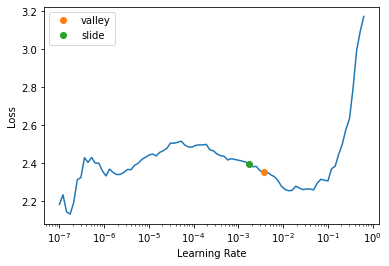

In [25]:
set_seed(42);set_fast_norm()

with IPyExperimentsPytorch(exp_enable=False, cl_set_seed=42, cl_compact=True):
                           
    dls = get_dls(0, size=SZ, bs=BS)
    
    learn = vision_learner(dls, TIMM_MODEL, n_out=dls.c, pretrained=True,
                           loss_func=CrossEntropyLossFlat(), metrics=[accuracy], 
                           splitter=partial(timm_split, cut=-3), act_layer=nn.Mish).to_fp16()
    
    print(learn.lr_find(suggest_funcs=(valley, slide)))

In [26]:
n_epo = 15; base_lr = 0.003;
SUFFIX = f"{SZ}_bs{BS}_epo{n_epo}_albu_mixup_ft"
print(EXP_NAME+'_'+SUFFIX)
set_seed(42); set_fast_norm()

NB_EXP_014_efficientnetv2_m_320_bs32_epo15_albu_mixup_ft


In [29]:
for fold_idx in range(NFOLDS):
    with IPyExperimentsPytorch(exp_enable=False, cl_set_seed=42, cl_compact=True):
        
        with wandb.init(project='pog3_corn',
                        group=EXP_NAME, 
                        save_code=True,
                        name=f'{EXP_NAME}_{SUFFIX}_CV_{fold_idx:02d}'):
            
            print()
            print('*' * 100)
            print(f'Training fold {fold_idx}')
            print('*' * 100)
        
            dls = get_dls(fold_idx, size=SZ, bs=BS)

            learn = vision_learner(dls, TIMM_MODEL, n_out=dls.c, pretrained=True,
                                   loss_func=CrossEntropyLossFlat(), metrics=[accuracy], 
                                   splitter=partial(timm_split, cut=-3), act_layer=nn.Mish).to_fp16()

            cbs = [SaveModelCallback(monitor="accuracy", comp=np.greater),
                   WandbCallback(log_preds=None), MixUp(alpha=0.4)]
            
            learn.fine_tune(n_epo, base_lr, cbs=cbs)

            learn = learn.load("model")
            learn = learn.to_fp32()

            dirpath = MODEL_FOLDER/f'{EXP_NAME}_{SUFFIX}_CV_{fold_idx:02d}'
            learn.save(dirpath, with_opt=False)


*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)




****************************************************************************************************
Training fold 0
****************************************************************************************************


epoch,train_loss,valid_loss,accuracy,time
0,1.301030,0.993814,0.593019,01:07


Better model found at epoch 0 with accuracy value: 0.5930191874504089.


epoch,train_loss,valid_loss,accuracy,time
0,1.023316,0.773755,0.686911,01:33
1,0.922031,0.669876,0.731239,01:33
2,0.872439,0.650129,0.735428,01:33
3,0.878338,0.580196,0.768586,01:33
4,0.848173,0.625998,0.744852,01:33
5,0.833077,0.607033,0.759860,01:33
6,0.803285,0.553238,0.779756,01:33
7,0.779185,0.539742,0.781850,01:33
8,0.773981,0.514572,0.792670,01:34
9,0.736430,0.532513,0.780803,01:34


Better model found at epoch 0 with accuracy value: 0.6869109869003296.
Better model found at epoch 1 with accuracy value: 0.7312390804290771.
Better model found at epoch 2 with accuracy value: 0.7354275584220886.
Better model found at epoch 3 with accuracy value: 0.7685863971710205.
Better model found at epoch 6 with accuracy value: 0.7797556519508362.
Better model found at epoch 7 with accuracy value: 0.7818499207496643.
Better model found at epoch 8 with accuracy value: 0.7926701307296753.
Better model found at epoch 10 with accuracy value: 0.8045375347137451.
Better model found at epoch 12 with accuracy value: 0.8052356243133545.
Better model found at epoch 13 with accuracy value: 0.8129144906997681.
CPU: 12/104/4389 MB | GPU: 2588/3944/8165 MB | Time 0:24:56.996 | (Consumed/Peaked/Used Total)

*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)




****************************************************************************************************
Training fold 1
****************************************************************************************************


epoch,train_loss,valid_loss,accuracy,time
0,1.324122,1.164520,0.524258,01:08


Better model found at epoch 0 with accuracy value: 0.5242583155632019.


epoch,train_loss,valid_loss,accuracy,time
0,1.020215,0.736021,0.700175,01:34
1,0.904207,0.627189,0.753927,01:34
2,0.888378,0.622822,0.747644,01:34
3,0.865460,0.721325,0.728098,01:34
4,0.840535,0.640932,0.741361,01:34
5,0.812000,0.553829,0.781152,01:34
6,0.816555,0.529077,0.792670,01:34
7,0.795612,0.566683,0.777312,01:34
8,0.780705,0.566794,0.774520,01:34
9,0.764531,0.536600,0.788482,01:34


Better model found at epoch 0 with accuracy value: 0.7001745104789734.
Better model found at epoch 1 with accuracy value: 0.753926694393158.
Better model found at epoch 5 with accuracy value: 0.7811518311500549.
Better model found at epoch 6 with accuracy value: 0.7926701307296753.
Better model found at epoch 10 with accuracy value: 0.800000011920929.
Better model found at epoch 12 with accuracy value: 0.8041884899139404.
Better model found at epoch 13 with accuracy value: 0.8055846691131592.
CPU: 6/98/4396 MB | GPU: 40/4458/8205 MB | Time 0:25:04.057 | (Consumed/Peaked/Used Total)

*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)




****************************************************************************************************
Training fold 2
****************************************************************************************************


epoch,train_loss,valid_loss,accuracy,time
0,1.304283,1.039074,0.592877,01:08


Better model found at epoch 0 with accuracy value: 0.5928770899772644.


epoch,train_loss,valid_loss,accuracy,time
0,1.018213,0.747925,0.696927,01:34
1,0.920037,0.650189,0.743017,01:34
2,0.877878,0.633643,0.747905,01:34
3,0.867376,0.627755,0.752444,01:34
4,0.853527,0.618805,0.760475,01:34
5,0.837815,0.613600,0.761173,01:34
6,0.816072,0.565474,0.773045,01:34
7,0.784020,0.594387,0.757332,01:33
8,0.780766,0.560985,0.774791,01:34
9,0.736588,0.515503,0.794693,01:34


Better model found at epoch 0 with accuracy value: 0.6969273686408997.
Better model found at epoch 1 with accuracy value: 0.74301677942276.
Better model found at epoch 2 with accuracy value: 0.7479050159454346.
Better model found at epoch 3 with accuracy value: 0.7524441480636597.
Better model found at epoch 4 with accuracy value: 0.7604748606681824.
Better model found at epoch 5 with accuracy value: 0.7611731886863708.
Better model found at epoch 6 with accuracy value: 0.7730447053909302.
Better model found at epoch 8 with accuracy value: 0.7747905254364014.
Better model found at epoch 9 with accuracy value: 0.7946927547454834.
Better model found at epoch 10 with accuracy value: 0.7953910827636719.
Better model found at epoch 11 with accuracy value: 0.7957402467727661.
Better model found at epoch 12 with accuracy value: 0.8041201233863831.
CPU: 6/98/4403 MB | GPU: 418/4242/8623 MB | Time 0:25:08.218 | (Consumed/Peaked/Used Total)

*** Experiment started with the Pytorch backend
Device


****************************************************************************************************
Training fold 3
****************************************************************************************************


epoch,train_loss,valid_loss,accuracy,time
0,1.336228,1.124752,0.498603,01:08


Better model found at epoch 0 with accuracy value: 0.49860334396362305.


epoch,train_loss,valid_loss,accuracy,time
0,1.004337,0.794177,0.682961,01:34
1,0.931522,0.656067,0.745112,01:34
2,0.898391,0.639259,0.747556,01:34
3,0.874768,0.654693,0.735335,01:34
4,0.868235,0.650198,0.743715,01:34
5,0.836937,0.600420,0.761522,01:34
6,0.832733,0.611388,0.757332,01:34
7,0.796829,0.535240,0.793645,01:35
8,0.768110,0.525360,0.791201,01:35
9,0.764295,0.524572,0.794344,01:35


Better model found at epoch 0 with accuracy value: 0.6829608678817749.
Better model found at epoch 1 with accuracy value: 0.7451117038726807.
Better model found at epoch 2 with accuracy value: 0.7475558519363403.
Better model found at epoch 5 with accuracy value: 0.7615223526954651.
Better model found at epoch 7 with accuracy value: 0.7936452627182007.
Better model found at epoch 9 with accuracy value: 0.7943435907363892.
Better model found at epoch 10 with accuracy value: 0.8002793192863464.
Better model found at epoch 11 with accuracy value: 0.8013268113136292.
Better model found at epoch 12 with accuracy value: 0.8051676154136658.
CPU: 0/95/4403 MB | GPU: -22/4192/8601 MB | Time 0:25:11.273 | (Consumed/Peaked/Used Total)

*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)




****************************************************************************************************
Training fold 4
****************************************************************************************************


epoch,train_loss,valid_loss,accuracy,time
0,1.311707,1.069185,0.538408,01:08


Better model found at epoch 0 with accuracy value: 0.5384078025817871.


epoch,train_loss,valid_loss,accuracy,time
0,1.024404,0.742481,0.698324,01:34
1,0.919532,0.657899,0.741969,01:34
2,0.887254,0.607719,0.762570,01:34
3,0.857859,0.567516,0.787011,01:34
4,0.849845,0.624152,0.751047,01:34
5,0.850623,0.566466,0.785265,01:34
6,0.822474,0.566429,0.781075,01:34
7,0.793828,0.543472,0.785964,01:34
8,0.788725,0.507401,0.811103,01:34
9,0.766292,0.514511,0.802025,01:35


Better model found at epoch 0 with accuracy value: 0.6983240246772766.
Better model found at epoch 1 with accuracy value: 0.7419692873954773.
Better model found at epoch 2 with accuracy value: 0.7625698447227478.
Better model found at epoch 3 with accuracy value: 0.7870111465454102.
Better model found at epoch 8 with accuracy value: 0.811103343963623.
Better model found at epoch 10 with accuracy value: 0.813896656036377.
Better model found at epoch 12 with accuracy value: 0.8222765326499939.
CPU: -26/69/4376 MB | GPU: -128/4100/8473 MB | Time 0:25:10.463 | (Consumed/Peaked/Used Total)


In [62]:
pattern = f'{EXP_NAME}_{SUFFIX}_CV_' + '{fold:02d}'
folds_val_score = []

with IPyExperimentsPytorch(exp_enable=False, cl_set_seed=42, cl_compact=True):
    
    for fold_index in range(NFOLDS):
        
        dls = get_dls(fold_index, size=SZ, bs=BS)

        learn = vision_learner(dls, TIMM_MODEL, n_out=dls.c, pretrained=False,
                               loss_func=CrossEntropyLossFlat(), metrics=[accuracy], 
                               splitter=partial(timm_split, cut=-3),
                               model_dir=MODEL_FOLDER,act_layer=Mish).to_fp16()
        
        checkpoint = pattern.format(fold=fold_index)
        print(f"--> Load from : {checkpoint!r} ({fold_index:02d})")
        
        learn.load(checkpoint)
        
        # no augs
        tst_dl = dls.valid.new()
        
        # hflip augs
        tst_dl_hflip = dls.valid.new()
        tst_dl_hflip.after_batch.add(hflip)
        
        # vflip augs
        tst_dl_vflip = dls.valid.new()
        tst_dl_vflip.after_batch.add(vflip)
        
        # hflip + vflip augs
        tst_dl_hlip_vflip = dls.valid.new()
        tst_dl_hlip_vflip.after_batch.add([hflip,vflip])
            
        dls = [tst_dl,tst_dl_hflip,tst_dl_vflip,tst_dl_hlip_vflip]
        n = len(dls)
        learn([event.before_fit, event.before_epoch])
        
        aug_preds = []
        with learn.no_mbar():
            if hasattr(learn,'progress'): learn.progress.mbar = master_bar(list(range(n)))
            
            for i in learn.progress.mbar if hasattr(learn,'progress') else range(n):
                learn.epoch = i
                with dls[i].dataset.set_split_idx(1): preds,targs = learn.get_preds(dl=dls[i], inner=True)
                aug_preds.append(preds[None])
        
        learn.epoch = n
        
        aug_preds = torch.cat(aug_preds)
        aug_preds = aug_preds.mean(0)
        acc = accuracy(aug_preds, targs).item()
        print(f"* Accuracy : {acc}")
        print()
        
        folds_val_score.append(acc)
        learn(event.after_fit)
        
           
print()
print('*' * 100)
print(f'Run summary: ')
print('*' * 100)
print("folds score: ", [np.round(s, 5) for s in folds_val_score])
print("Avg: {:.5f}".format(np.mean(folds_val_score)))
print("Std: {:.5f}".format(np.std(folds_val_score)))


*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)

--> Load from : 'NB_EXP_014_efficientnetv2_m_320_bs32_epo15_albu_mixup_ft_CV_00' (00)


* Accuracy : 0.8153577446937561

--> Load from : 'NB_EXP_014_efficientnetv2_m_320_bs32_epo15_albu_mixup_ft_CV_01' (01)


* Accuracy : 0.8139616250991821

--> Load from : 'NB_EXP_014_efficientnetv2_m_320_bs32_epo15_albu_mixup_ft_CV_02' (02)


* Accuracy : 0.811103343963623

--> Load from : 'NB_EXP_014_efficientnetv2_m_320_bs32_epo15_albu_mixup_ft_CV_03' (03)


* Accuracy : 0.8104050159454346

--> Load from : 'NB_EXP_014_efficientnetv2_m_320_bs32_epo15_albu_mixup_ft_CV_04' (04)


* Accuracy : 0.8299580812454224

CPU: 101/46/4875 MB | GPU: 762/412/6437 MB | Time 0:02:09.026 | (Consumed/Peaked/Used Total)

****************************************************************************************************
Run summary: 
****************************************************************************************************
folds score:  [0.81536, 0.81396, 0.8111, 0.81041, 0.82996]
Avg: 0.81616
Std: 0.00714


In [63]:
pattern = f'{EXP_NAME}_{SUFFIX}_CV_' + '{fold:02d}'
folds_val_score = []

with IPyExperimentsPytorch(exp_enable=False, cl_set_seed=42, cl_compact=True):
    
    for fold_index in range(NFOLDS):
        
        dls = get_dls(fold_index, size=SZ, bs=BS)

        learn = vision_learner(dls, TIMM_MODEL, n_out=dls.c, pretrained=False,
                               loss_func=CrossEntropyLossFlat(), metrics=[accuracy], 
                               splitter=partial(timm_split, cut=-3),
                               model_dir=MODEL_FOLDER,act_layer=Mish).to_fp16()
        
        checkpoint = pattern.format(fold=fold_index)
        print(f"--> Load from : {checkpoint!r} ({fold_index:02d})")
        
        learn.load(checkpoint)
        
        # no augs
        tst_dl = dls.valid.new()
        
        # hflip augs
        tst_dl_hflip = dls.valid.new()
        tst_dl_hflip.after_batch.add(hflip)
        
        # vflip augs
        tst_dl_vflip = dls.valid.new()
        tst_dl_vflip.after_batch.add(vflip)
        
        # hflip + vflip augs
#         tst_dl_hlip_vflip = dls.valid.new()
#         tst_dl_hlip_vflip.after_batch.add([hflip,vflip])
            
        dls = [tst_dl,tst_dl_hflip,tst_dl_vflip]#,tst_dl_hlip_vflip]
        n = len(dls)
        learn([event.before_fit, event.before_epoch])
        
        aug_preds = []
        with learn.no_mbar():
            if hasattr(learn,'progress'): learn.progress.mbar = master_bar(list(range(n)))
            
            for i in learn.progress.mbar if hasattr(learn,'progress') else range(n):
                learn.epoch = i
                with dls[i].dataset.set_split_idx(1): preds,targs = learn.get_preds(dl=dls[i], inner=True)
                aug_preds.append(preds[None])
        
        learn.epoch = n
        
        aug_preds = torch.cat(aug_preds)
        aug_preds = aug_preds.mean(0)
        acc = accuracy(aug_preds, targs).item()
        print(f"* Accuracy : {acc}")
        print()
        
        folds_val_score.append(acc)
        learn(event.after_fit)
        
           
print()
print('*' * 100)
print(f'Run summary: ')
print('*' * 100)
print("folds score: ", [np.round(s, 5) for s in folds_val_score])
print("Avg: {:.5f}".format(np.mean(folds_val_score)))
print("Std: {:.5f}".format(np.std(folds_val_score)))


*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)

--> Load from : 'NB_EXP_014_efficientnetv2_m_320_bs32_epo15_albu_mixup_ft_CV_00' (00)


* Accuracy : 0.8139616250991821

--> Load from : 'NB_EXP_014_efficientnetv2_m_320_bs32_epo15_albu_mixup_ft_CV_01' (01)


* Accuracy : 0.8111692667007446

--> Load from : 'NB_EXP_014_efficientnetv2_m_320_bs32_epo15_albu_mixup_ft_CV_02' (02)


* Accuracy : 0.8131983280181885

--> Load from : 'NB_EXP_014_efficientnetv2_m_320_bs32_epo15_albu_mixup_ft_CV_03' (03)


* Accuracy : 0.8125

--> Load from : 'NB_EXP_014_efficientnetv2_m_320_bs32_epo15_albu_mixup_ft_CV_04' (04)


* Accuracy : 0.8271648287773132

CPU: 98/43/4973 MB | GPU: 562/500/6999 MB | Time 0:01:38.051 | (Consumed/Peaked/Used Total)

****************************************************************************************************
Run summary: 
****************************************************************************************************
folds score:  [0.81396, 0.81117, 0.8132, 0.8125, 0.82716]
Avg: 0.81560
Std: 0.00586
